In [119]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

import analysis_plotting_helper_functions_c3v3 as helper
import utils

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
figure_folder = os.path.join(data_dir, f'{exp}_figures')
os.makedirs(figure_folder, exist_ok=True)

print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/exp2
/Users/rebekahzhang/data/behavior_data/exp2_figures


In [3]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [4]:
sessions_training = pd.read_csv(os.path.join(data_folder, f'sessions_training_{exp}.csv'))
sessions_training['period'] = sessions_training['session']//10
trials_training = utils.load_data(os.path.join(data_folder, 'trials_training_analyzed.csv'))

In [106]:
sessions_training.mouse.nunique()
sessions_training.groupby('group')['mouse'].nunique()

group
l    19
s    14
Name: mouse, dtype: int64

# Dataset overview

In [6]:
print(f'{len(sessions_training)} sessions')
print(f'{len(trials_training)} trials')

1852 sessions
652754 trials


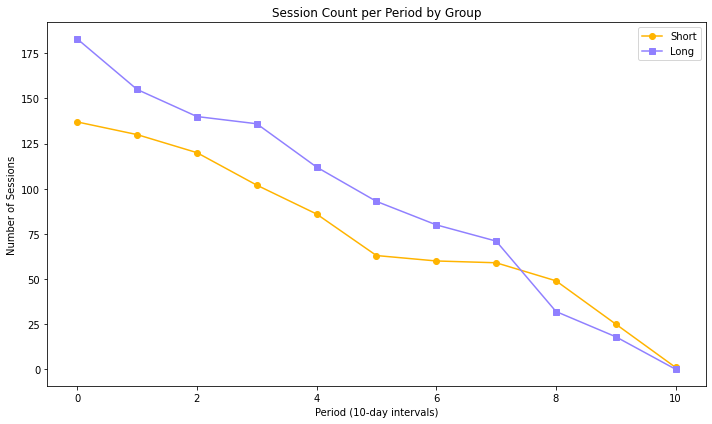

In [7]:
plt.figure(figsize=(10, 6))

session_counts = sessions_training.groupby(['period', 'group']).size().unstack(fill_value=0)
plt.plot(session_counts.index, session_counts['s'], marker='o', label='Short', color=custom_palette['s'])
plt.plot(session_counts.index, session_counts['l'], marker='s', label='Long', color=custom_palette['l'])

plt.xlabel('Period (10-day intervals)')
plt.ylabel('Number of Sessions')
plt.title('Session Count per Period by Group')
plt.legend()  # Add legend

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "session_count_by_period_by_group.png"))

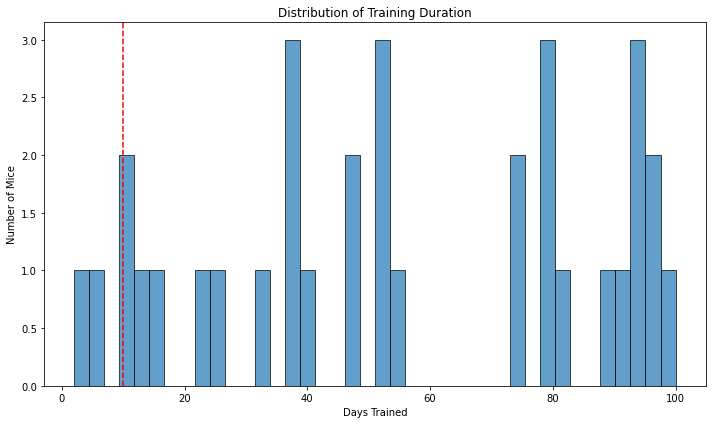

In [8]:
# Get training duration stats
training_duration = sessions_training.groupby('mouse')['session'].max()

plt.figure(figsize=(10, 6))
plt.hist(training_duration, bins=40, alpha=0.7, edgecolor='black')
plt.axvline(x=10, color='red', linestyle='--', label='Cutoff (10 sessions)')
plt.xlabel('Days Trained')
plt.ylabel('Number of Mice')
plt.title('Distribution of Training Duration')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "training_duration_distribution.png"))

### make wait df, 1 row per session

In [9]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group', 'period']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [10]:
wait_df = generate_wait_df(sessions_training)

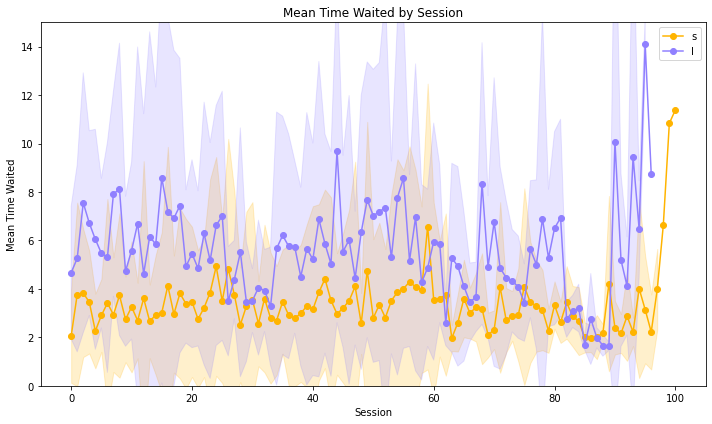

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Calculate mean and std for each group by session
for group in wait_df['group'].unique():
    group_data = wait_df[wait_df['group'] == group]
    session_stats = group_data.groupby('session')['tw_mean'].agg(['mean', 'std']).reset_index()
    
    ax.plot(session_stats['session'], session_stats['mean'], marker='o', label=group, color=custom_palette[group])
    ax.fill_between(session_stats['session'], 
                   session_stats['mean'] - session_stats['std'],
                   session_stats['mean'] + session_stats['std'],
                   alpha=0.2, color=custom_palette[group])

ax.set_xlabel('Session')
ax.set_ylabel('Mean Time Waited')
ax.set_title('Mean Time Waited by Session')
ax.legend()
ax.set_ylim(0, 15)

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "tw_by_session_by_group.png"))

# Filter late sessions, early termination mice, outlier mice

### late sessions

In [12]:
session_cap = 80

In [13]:
sessions_training_caped = sessions_training.loc[sessions_training['session'] <= session_cap]
trials_training_caped = trials_training.loc[trials_training['session'] <= session_cap]

print(f'{len(sessions_training_caped)} sessions')
print(f'{len(trials_training_caped)} trials')

1736 sessions
612674 trials


### early termination mice

In [14]:
# Get mice with >= 10 sessions
valid_mice = training_duration[training_duration >= 10].index.tolist()
sessions_training_filtered1 = sessions_training_caped[sessions_training_caped['mouse'].isin(valid_mice)].reset_index(drop=True)
trials_training_filtered1 = trials_training_caped[trials_training_caped['mouse'].isin(valid_mice)].reset_index(drop=True)

print(f'{len(sessions_training_filtered1)} sessions')
print(f'{len(trials_training_filtered1)} trials')


1726 sessions
608769 trials


In [15]:
wait_by_session_filted1 = generate_wait_df(sessions_training_filtered1)

### outlier mice

In [16]:
mice_s = sessions_training_filtered1[sessions_training_filtered1['group'] == 's']['mouse'].unique()
mice_l = sessions_training_filtered1[sessions_training_filtered1['group'] == 'l']['mouse'].unique()

s_colors = plt.cm.twilight(np.linspace(0, 1, len(mice_s)))
l_colors = plt.cm.twilight_shifted(np.linspace(0, 1, len(mice_l)))
s_mouse_palette = dict(zip(mice_s, s_colors))
l_mouse_palette = dict(zip(mice_l, l_colors))
mouse_palette = {**s_mouse_palette, **l_mouse_palette}

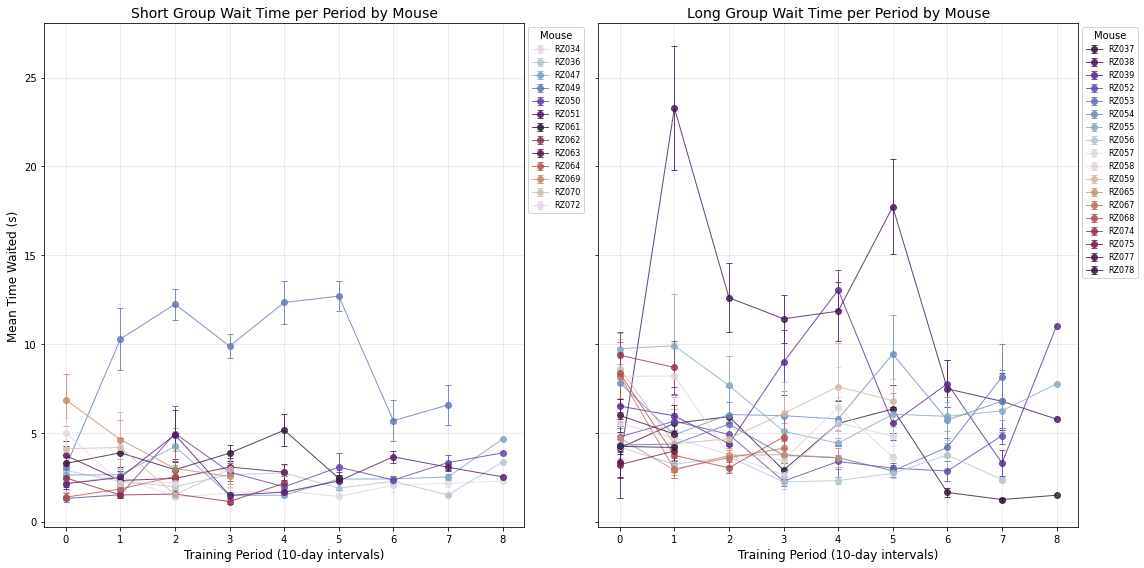

In [17]:

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

groups = ['s', 'l']
titles = ['Short Group Wait Time per Period by Mouse', 'Long Group Wait Time per Period by Mouse']

for ax, group, title in zip(axes, groups, titles):
    group_df = wait_by_session_filted1[wait_by_session_filted1['group'] == group]
    # Compute mean and std for each mouse and period
    agg = group_df.groupby(['mouse', 'period'], as_index=False).agg(
        tw_mean=('tw_mean', 'mean'),
        tw_std=('tw_mean', 'std'),
        n=('tw_mean', 'count')
    )
    # Calculate standard error
    agg['tw_se'] = agg['tw_std'] / np.sqrt(agg['n'])

    mice = agg['mouse'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(mice)))

    for mouse, color in zip(mice, colors):
        data = agg[agg['mouse'] == mouse].sort_values('period')
        ax.errorbar(
            data['period'], data['tw_mean'], yerr=data['tw_se'],
            fmt='-o', color=mouse_palette[mouse], label=mouse, alpha=0.8, lw=1, capsize=3
        )

    ax.set_xlabel('Training Period (10-day intervals)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(sorted(agg['period'].unique()))
    ax.grid(alpha=0.3)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=8, title='Mouse')

axes[0].set_ylabel('Mean Time Waited (s)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "tw_by_mouse_by_period_by_group.png"))

In [18]:
def generate_mouse_wait_df(wait_df):
    data_list = []
    wait_df_by_mouse = wait_df.groupby('mouse')
    for m, mouse_data in wait_df_by_mouse:
        avg_avg_tw = mouse_data['tw_mean'].mean()
        data = {"mouse": m, 'tw': avg_avg_tw, 'group':mouse_data.group.tolist()[0]}
        data_list.append(data)
    mouse_wait_df = pd.DataFrame(data_list).sort_values(by=['group','tw'])
    return mouse_wait_df

In [19]:
mouse_wait_df = generate_mouse_wait_df(wait_by_session_filted1)
display(mouse_wait_df)

,mouse,tw,group
13,RZ056,3.087526,l
28,RZ075,3.459309,l
21,RZ065,3.764084,l
9,RZ052,3.946847,l
2,RZ037,4.117569,l
30,RZ078,4.221868,l
14,RZ057,4.465237,l
10,RZ053,4.580090,l
22,RZ067,4.753247,l
23,RZ068,4.977629,l


In [20]:
def find_outlier_mice(mouse_wait_df, method='iqr', multiplier=3):
    """
    Find outlier mice within each group based on tw values.
    """
    outliers = []
    for group, group_data in mouse_wait_df.groupby('group'):
        tw = group_data['tw']
        if method == 'iqr':
            q1, q3 = tw.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower, upper = q1 - multiplier * iqr, q3 + multiplier * iqr
            mask = (tw < lower) | (tw > upper)
        elif method == 'zscore':
            mean, std = tw.mean(), tw.std()
            mask = abs((tw - mean) / std) > multiplier
        else:
            raise ValueError("method must be 'iqr' or 'zscore'")
        for _, row in group_data[mask].iterrows():
            outliers.append({'mouse': row['mouse'], 'group': row['group'], 'tw': row['tw'],
                             'method': method, 'is_outlier': True})
    return pd.DataFrame(outliers)

In [21]:
# Find outliers using IQR method
outliers_iqr = find_outlier_mice(mouse_wait_df, method='iqr', multiplier=1.5)
print("Outliers using IQR method (1.5x IQR):")
print(outliers_iqr)

# Find outliers using z-score method
outliers_zscore = find_outlier_mice(mouse_wait_df, method='zscore', multiplier=2.0)
print("\nOutliers using Z-score method (|z| > 2):")
print(outliers_zscore)

Outliers using IQR method (1.5x IQR):
   mouse group         tw method  is_outlier
0  RZ038     l  11.731679    iqr        True
1  RZ049     s   9.125444    iqr        True

Outliers using Z-score method (|z| > 2):
   mouse group         tw  method  is_outlier
0  RZ038     l  11.731679  zscore        True
1  RZ049     s   9.125444  zscore        True


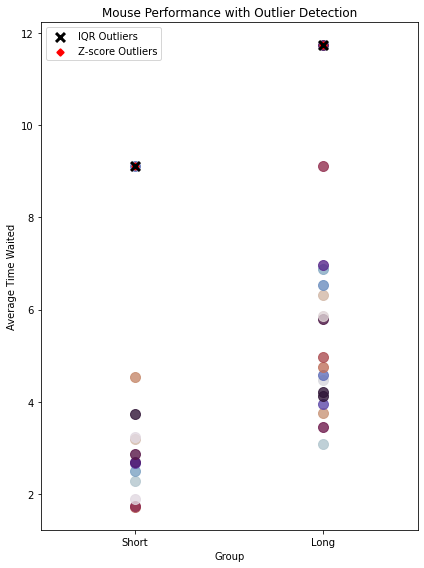

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
group_order = ['s', 'l']
group_labels = ['Short', 'Long']

# Plot all mice
for i, group in enumerate(group_order):
    group_data = mouse_wait_df[mouse_wait_df['group'] == group]
    for _, mouse_row in group_data.iterrows():
        ax.scatter(i, mouse_row['tw'],
                   color=mouse_palette[mouse_row['mouse']],
                   alpha=0.8, s=100, zorder=1)

# Mark outliers with different markers
for i, group in enumerate(group_order):
    group_data = mouse_wait_df[mouse_wait_df['group'] == group]
    
    # IQR outliers (X marker)
    iqr_outliers = outliers_iqr[outliers_iqr['group'] == group]['mouse'].tolist()
    iqr_data = group_data[group_data['mouse'].isin(iqr_outliers)]
    ax.scatter([i] * len(iqr_data), iqr_data['tw'],
                color='k', s=80, marker='x', linewidth=3,
                label='IQR Outliers' if group == 's' else "", zorder=3)
    
    # Z-score outliers (diamond marker)
    zscore_outliers = outliers_zscore[outliers_zscore['group'] == group]['mouse'].tolist()
    zscore_data = group_data[group_data['mouse'].isin(zscore_outliers)]
    ax.scatter([i] * len(zscore_data), zscore_data['tw'],
                color='red', s=20, marker='D', linewidth=2,
                label='Z-score Outliers' if group == 's' else "", zorder=2)

ax.set_xlabel('Group')
ax.set_ylabel('Average Time Waited')
ax.set_title('Mouse Performance with Outlier Detection')
ax.set_xticks([0, 1])
ax.set_xticklabels(group_labels)
ax.set_xlim(-0.5, 1.5)
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "outlier_mouse_comparison_iqr_zscore.png"))

In [23]:
outlier_mice = outliers_iqr['mouse'].tolist()

In [24]:
sessions_training_filtered2 = sessions_training_filtered1[~sessions_training_filtered1['mouse'].isin(outlier_mice)]
trials_training_filtered2 = trials_training_filtered1[~trials_training_filtered1['mouse'].isin(outlier_mice)]
wait_by_session_filted2 = wait_by_session_filted1[~wait_by_session_filted1['mouse'].isin(outlier_mice)]

print(f'{len(sessions_training_filtered2)} sessions')
print(f'{len(trials_training_filtered2)} trials')

1566 sessions
572276 trials


In [25]:
tw_short = trials_training_filtered2[trials_training_filtered2['group'] == 's'].time_waited.mean()
print("Short tw mean: ", tw_short)
tw_long = trials_training_filtered2[trials_training_filtered2['group'] == 'l'].time_waited.mean()
print("Long tw mean: ", tw_long)

Short tw mean:  2.2554517514439425
Long tw mean:  4.328811655927012


In [26]:
sessions_training_filtered2.to_csv(os.path.join(data_folder, 'sessions_training_filtered2.csv'), index=False)
trials_training_filtered2.to_csv(os.path.join(data_folder, 'trials_training_filtered2.csv'), index=False)

# Performance Stats

In [27]:
sessions_training_filtered2 = pd.read_csv(os.path.join(data_folder, 'sessions_training_filtered2.csv'))
trials_training_filtered2 = pd.read_csv(os.path.join(data_folder, 'trials_training_filtered2.csv'))

In [86]:
print("Number of unique mice by group:")
print(sessions_training_filtered2.groupby('group')['mouse'].nunique())

print("Number of unique sessions by group:")
print(sessions_training_filtered2.groupby('group')['dir'].nunique())

Number of unique mice by group:
group
l    17
s    12
Name: mouse, dtype: int64
Number of unique sessions by group:
group
l    890
s    676
Name: dir, dtype: int64


In [92]:
sessions_tw_short = sessions_training_filtered2[sessions_training_filtered2['group'] == 's']['avg_tw']
sessions_tw_long = sessions_training_filtered2[sessions_training_filtered2['group'] == 'l']['avg_tw']
t_stat, p_value = stats.ttest_ind(sessions_tw_short, sessions_tw_long)
print(f"S: n={len(sessions_tw_short)}, mean={sessions_tw_short.mean():.3f}±{sessions_tw_short.std():.3f}s")
print(f"L: n={len(sessions_tw_long)}, mean={sessions_tw_long.mean():.3f}±{sessions_tw_long.std():.3f}s")
print(f"T-test: t={t_stat:.3f}, p={p_value}")

S: n=676, mean=2.674±2.240s
L: n=890, mean=4.636±3.835s
T-test: t=-11.852, p=4.310154586388674e-31


In [94]:
tw_short_all = trials_training_filtered2[trials_training_filtered2['group'] == 's'].time_waited
tw_long_all = trials_training_filtered2[trials_training_filtered2['group'] == 'l'].time_waited
t_stat, p_value = stats.ttest_ind(tw_short_all, tw_long_all)
print(f'{len(trials_training_filtered2)} all trials')
print(f"S: n={len(tw_short_all)}, mean={tw_short_all.mean():.3f}±{tw_short_all.std():.3f}s")
print(f"L: n={len(tw_long_all)}, mean={tw_long_all.mean():.3f}±{tw_long_all.std():.3f}s")
print(f"T-test: t={t_stat:.3f}, p={p_value}\n")

trials_training_filtered2_no_repeat = trials_training_filtered2[trials_training_filtered2['bg_repeats'] == 1]
tw_short_np = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 's'].time_waited
tw_long_np = trials_training_filtered2_no_repeat[trials_training_filtered2_no_repeat['group'] == 'l'].time_waited
t_stat, p_value = stats.ttest_ind(tw_short_np, tw_long_np)
print(f'{len(trials_training_filtered2_no_repeat)} no repeat trials')
print(f"S: n={len(tw_short_np)}, mean={tw_short_np.mean():.3f}±{tw_short_np.std():.3f}s")
print(f"L: n={len(tw_long_np)}, mean={tw_long_np.mean():.3f}±{tw_long_np.std():.3f}s")
print(f"T-test: t={t_stat:.3f}, p={p_value}")

572276 all trials
S: n=268944, mean=2.255±4.366s
L: n=303332, mean=4.329±9.281s
T-test: t=-105.923, p=0.0

299762 no repeat trials
S: n=146591, mean=2.610±5.491s
L: n=153171, mean=6.064±11.721s
T-test: t=-102.561, p=0.0


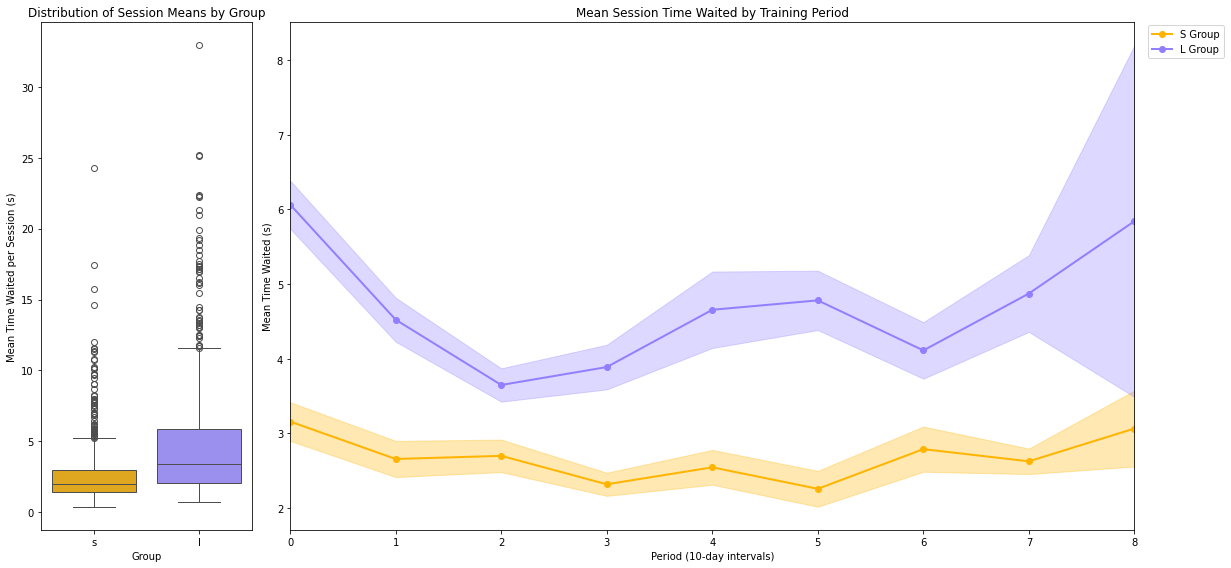

In [95]:
# Create figure with subplots (1 row, 2 columns with 1:3 width ratio)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 4]})

# Left subplot: Box plot
sns.boxplot(data=sessions_training_filtered2, x='group', y='avg_tw', hue='group', 
            palette=custom_palette, legend=False, ax=ax1)
ax1.set_xlabel('Group')
ax1.set_ylabel('Mean Time Waited per Session (s)')
ax1.set_title('Distribution of Session Means by Group')

# Right subplot: Line plot
# Calculate mean tw_mean by period and group
period_stats = sessions_training_filtered2.groupby(['period', 'group'])['avg_tw'].agg(['mean', 'std', 'count']).reset_index()
period_stats['se'] = period_stats['std'] / np.sqrt(period_stats['count'])

for group in ['s', 'l']:
    group_data = period_stats[period_stats['group'] == group]
    ax2.plot(group_data['period'], group_data['mean'], 
             marker='o', label=f'{group.upper()} Group', 
             color=custom_palette[group], linewidth=2, markersize=6)
    
    # Add error bars (standard error)
    ax2.fill_between(group_data['period'], 
                     group_data['mean'] - group_data['se'],
                     group_data['mean'] + group_data['se'],
                     alpha=0.3, color=custom_palette[group])

ax2.set_xlabel('Period (10-day intervals)')
ax2.set_ylabel('Mean Time Waited (s)')
ax2.set_title('Mean Session Time Waited by Training Period')
ax2.set_xlim(0, 8)

# Create single legend for the entire figure, positioned outside the plot area
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.07, 0.92))

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "avg_tw_by_period_by_group.png"))

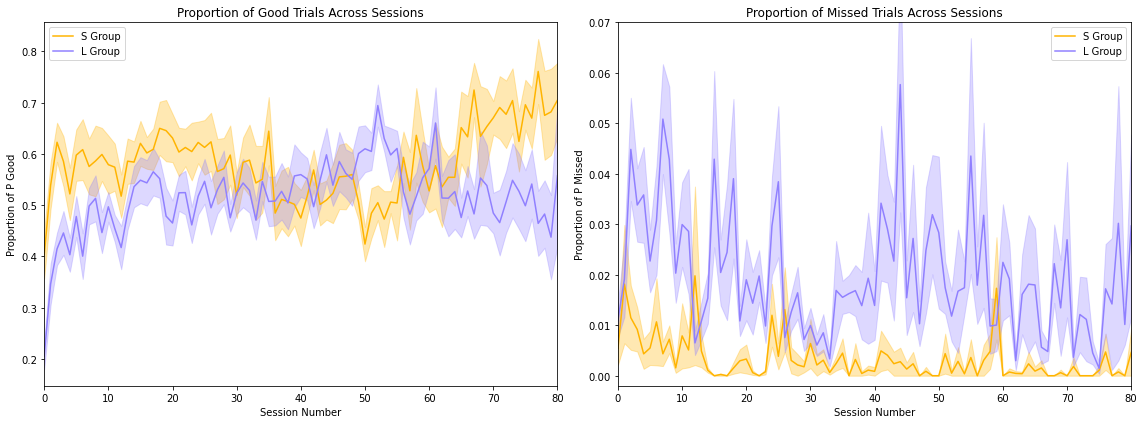

In [ ]:
# Calculate per-dir proportions of good and missed trials
def get_performance_by_dir(trials):
    results = []
    for _, d in trials.groupby('dir'):
        results.append({
            'group': d['group'].iloc[0],
            'session': d['session'].iloc[0],
            'p_good': d['good_trial'].mean(),
            'p_missed': d['miss_trial'].mean()
        })
    return pd.DataFrame(results)

performance_by_dir = get_performance_by_dir(trials_training_filtered2)

# Aggregate mean and standard error by group and session - simplified approach
trial_prop_stats = (
    performance_by_dir
    .groupby(['group', 'session'])[['p_good', 'p_missed']]
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
trial_prop_stats.columns = ['group', 'session', 'p_good_mean', 'p_good_std', 'p_good_count', 'p_missed_mean', 'p_missed_std', 'p_missed_count']

# Calculate standard error
trial_prop_stats['p_good_se'] = trial_prop_stats['p_good_std'] / np.sqrt(trial_prop_stats['p_good_count'])
trial_prop_stats['p_missed_se'] = trial_prop_stats['p_missed_std'] / np.sqrt(trial_prop_stats['p_missed_count'])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, col, title, ylim in zip(
    axes,
    ['p_good', 'p_missed'],
    ['Proportion of Good Trials Across Sessions', 'Proportion of Missed Trials Across Sessions'],
    [None, (-0.002, 0.07)]
):
    for group in ['s', 'l']:
        data = trial_prop_stats[trial_prop_stats['group'] == group]
        ax.plot(data['session'], data[f'{col}_mean'], color=custom_palette[group], label=f'{group.upper()} Group')
        ax.fill_between(
            data['session'],
            data[f'{col}_mean'] - data[f'{col}_se'],
            data[f'{col}_mean'] + data[f'{col}_se'],
            color=custom_palette[group], alpha=0.3
        )
    ax.set(
        title=title,
        xlabel='Session Number',
        ylabel=f'Proportion of {col.replace("_", " ").title()}',
        xlim=(0, 80)
    )
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()
plt.tight_layout()
plt.savefig(f'{figure_folder}/p_good_vs_missed_subplots_shading.png', dpi=300, bbox_inches='tight')


# LMEM

In [98]:
# --- coding & centering ---
lmem_data = trials_training_filtered2.copy()
lmem_data['group_numeric'] = (lmem_data['group'] == 'l').astype(int)
session_mean = lmem_data['session'].mean()
trial_mean   = lmem_data['session_trial_num'].mean()

# scale session by 10 to help convergence
lmem_data['session_c'] = (lmem_data['session'] - session_mean) / 10.0
lmem_data['trial_c']   = lmem_data['session_trial_num'] - trial_mean

# --- fit: fixed = group × (session_c + session_c^2) + trial_c; random = intercept + session_c
model = smf.mixedlm(
    "time_waited ~ group_numeric * session_c + group_numeric * I(session_c**2) + trial_c",
    data=lmem_data,
    groups=lmem_data["mouse"],
    re_formula="~session_c"
)
result = model.fit(method="lbfgs")
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      time_waited  
No. Observations:      572276       Method:                  REML         
No. Groups:            29           Scale:                   52.8872      
Min. group size:       2809         Log-Likelihood:          -1947644.9034
Max. group size:       35247        Converged:               Yes          
Mean group size:       19733.7                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        1.958    0.407  4.810 0.000  1.160  2.756
group_numeric                    2.058    0.538  3.826 0.000  1.004  3.113
session_c                       -0.177    0.145 -1.218 0.223 -0.462  0.108
group_numeric:session_c         -0.215    0.

In [99]:
# --- prediction grid at mean trial (trial_c=0) ---
sessions_raw = np.linspace(lmem_data['session'].min(), lmem_data['session'].max(), 200)
sessions_c   = (sessions_raw - session_mean) / 10.0
groups = ['l', 's']

pred_df = pd.DataFrame({
    'session_raw': np.tile(sessions_raw, 2),
    'session_c':   np.tile(sessions_c, 2),
    'group':       np.repeat(groups, len(sessions_raw)),
    'trial_c':     0.0,  # predict at mean trial
    'mouse':       lmem_data['mouse'].iloc[0],
})
pred_df['group_numeric'] = (pred_df['group'] == 'l').astype(int)
pred_df['pred_time'] = result.predict(pred_df)

# --- empirical mean ± SE by session × group ---
session_stats = (
    lmem_data
    .groupby(['session', 'group'], as_index=False)
    .agg(
        mean_tw=('time_waited', 'mean'),
        std_tw =('time_waited', 'std'),
        count  =('time_waited', 'count')
    )
)
session_stats['se_tw'] = session_stats['std_tw'] / np.sqrt(session_stats['count'].clip(lower=1))

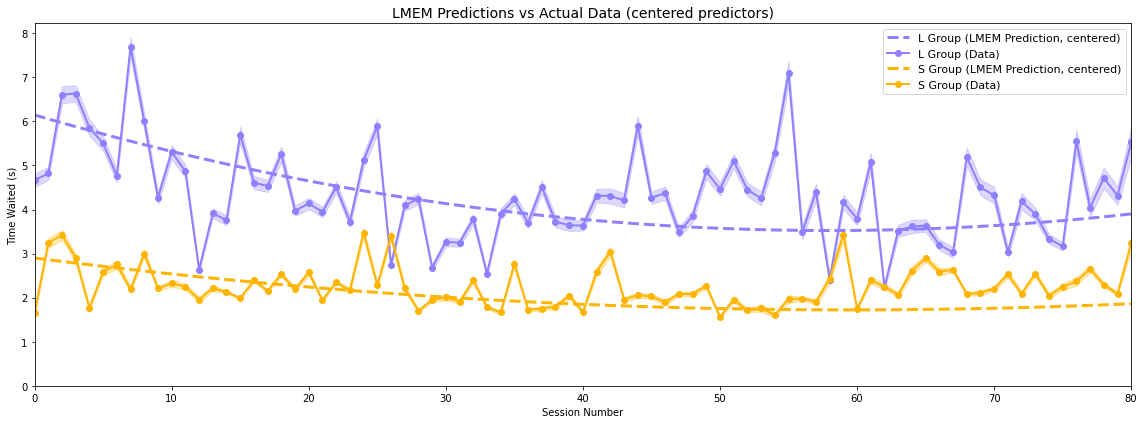

In [100]:
plt.figure(figsize=(16, 6))
for g in groups:
    sel = pred_df['group'] == g
    plt.plot(
        pred_df.loc[sel, 'session_raw'],
        pred_df.loc[sel, 'pred_time'],
        '--', linewidth=3, color=custom_palette[g],
        label=f'{g.upper()} Group (LMEM Prediction, centered)'
    )
    gd = session_stats[session_stats['group'] == g]
    plt.plot(
        gd['session'], gd['mean_tw'],
        'o-', markersize=6, linewidth=2, color=custom_palette[g],
        label=f'{g.upper()} Group (Data)'
    )
    plt.fill_between(
        gd['session'],
        gd['mean_tw'] - gd['se_tw'],
        gd['mean_tw'] + gd['se_tw'],
        alpha=0.3, color=custom_palette[g]
    )

plt.title('LMEM Predictions vs Actual Data (centered predictors)', fontsize=14)
plt.xlabel('Session Number'); plt.ylabel('Time Waited (s)')
plt.legend(fontsize=11); plt.xlim(lmem_data['session'].min(), lmem_data['session'].max())
plt.ylim(bottom=0); plt.tight_layout()
plt.savefig(f'{figure_folder}/predictions_centered.png', dpi=300, bbox_inches='tight')

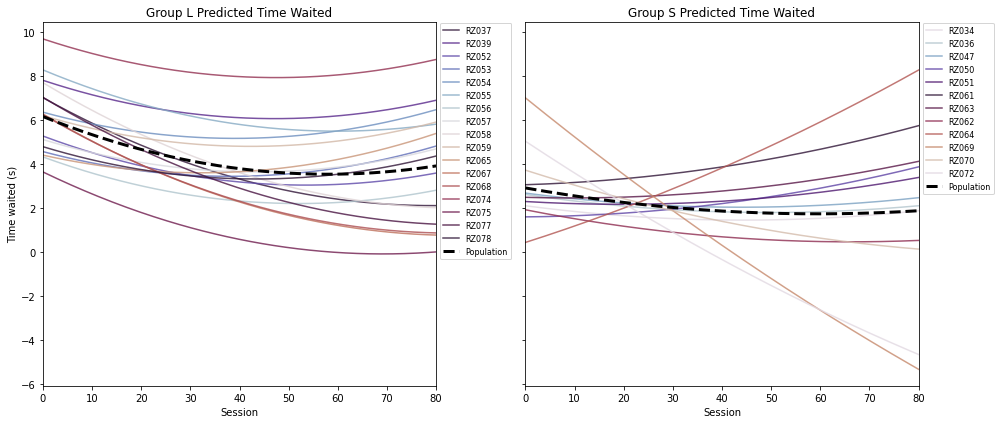

In [163]:
# Simplified: population line is black, legend moved to right, code streamlined

def get_u0_u1(u):
    # Extract random intercept and slope for a mouse
    u0 = u.get('Intercept', u.get('const', u.get('Group', u.iloc[0] if hasattr(u, "iloc") else 0.0)))
    u1 = u.get('session_c', 0.0)
    return float(u0), float(u1)

fe = result.params
def fe_predict(session_c, group_numeric, trial_c=0.0):
    return (
        fe['Intercept']
        + fe.get('group_numeric', 0.0) * group_numeric
        + fe.get('session_c', 0.0) * session_c
        + fe.get('group_numeric:session_c', 0.0) * group_numeric * session_c
        + fe.get('I(session_c ** 2)', 0.0) * (session_c ** 2)
        + fe.get('group_numeric:I(session_c ** 2)', 0.0) * group_numeric * (session_c ** 2)
        + fe.get('trial_c', 0.0) * trial_c
    )

session_mean = lmem_data['session'].mean()
sessions_raw = np.linspace(lmem_data['session'].min(), lmem_data['session'].max(), 200)
sessions_c = (sessions_raw - session_mean) / 10.0

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
group_list = ['l', 's']

for i, g in enumerate(group_list):
    ax = axes[i]
    gn = 1 if g == 'l' else 0

    # Plot each mouse's fitted curve
    mice = lmem_data.loc[lmem_data['group'] == g, 'mouse'].unique()
    for m in mice:
        u = result.random_effects.get(m)
        if u is None:
            continue
        u0, u1 = get_u0_u1(u)
        y_mouse = fe_predict(sessions_c, gn) + u0 + u1 * sessions_c
        color = mouse_palette.get(m, "#888888")
        ax.plot(sessions_raw, y_mouse, color=color, alpha=0.8, linewidth=1.5, label=m)

    # Overlay population curve in black
    y_pop = fe_predict(sessions_c, gn)
    ax.plot(sessions_raw, y_pop, '--', color='black', linewidth=3, label='Population')

    ax.set_title(f"Group {g.upper()} Predicted Time Waited")
    ax.set_xlabel('Session')
    if i == 0:
        ax.set_ylabel('Time waited (s)')
    ax.set_xlim(0, 80)
    # Legend to the right of each subplot
    ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1.01))

plt.tight_layout()
plt.savefig(f'{figure_folder}/predictions_centered_by_group.png', dpi=300, bbox_inches='tight')


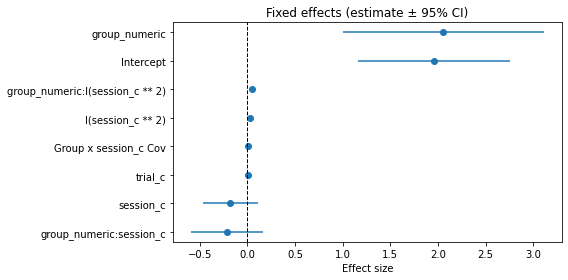

In [116]:
ci = result.conf_int()
coef = result.params
coef_df = pd.DataFrame({
    'term': coef.index,
    'est': coef.values,
    'lo': ci[0].values,
    'hi': ci[1].values
})

fixed_mask = ~coef_df['term'].str.contains('^Group Var|^session_c Var|^Intercept Var|^Cov|^Scale', regex=True)
coef_df = coef_df[fixed_mask]

coef_df = coef_df.sort_values('est')
plt.figure(figsize=(8, max(4, 0.5*len(coef_df))))
plt.hlines(y=coef_df['term'], xmin=coef_df['lo'], xmax=coef_df['hi'])
plt.plot(coef_df['est'], coef_df['term'], 'o')
plt.axvline(0, color='k', linewidth=1, linestyle='--')
plt.title('Fixed effects (estimate ± 95% CI)')
plt.xlabel('Effect size'); plt.tight_layout()
plt.savefig(f'{figure_folder}/fixed_effects_ci.png', dpi=300, bbox_inches='tight')

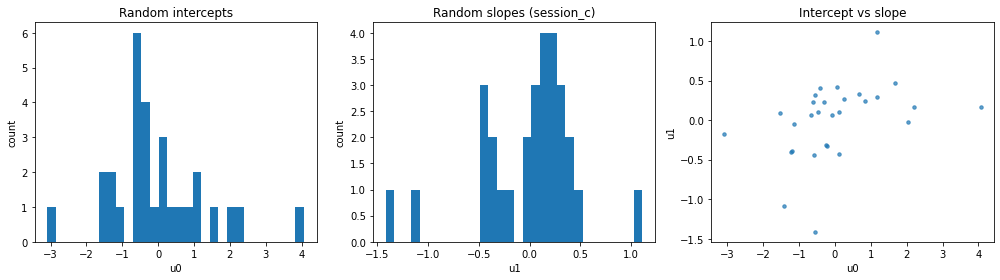

In [117]:
re_list = []
for m, u in result.random_effects.items():
    u0, u1 = (u.get('Intercept', u.get('const', u.get('Group', u.iloc[0]))),
              u.get('session_c', 0.0))
    re_list.append({'mouse': m, 'u0_intercept': float(u0), 'u1_session_c': float(u1)})
re_df = pd.DataFrame(re_list)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(re_df['u0_intercept'], bins=30)
plt.title('Random intercepts'); plt.xlabel('u0'); plt.ylabel('count')

plt.subplot(1,3,2)
plt.hist(re_df['u1_session_c'], bins=30)
plt.title('Random slopes (session_c)'); plt.xlabel('u1'); plt.ylabel('count')

plt.subplot(1,3,3)
plt.scatter(re_df['u0_intercept'], re_df['u1_session_c'], s=12, alpha=0.7)
plt.title('Intercept vs slope'); plt.xlabel('u0'); plt.ylabel('u1')
plt.tight_layout()

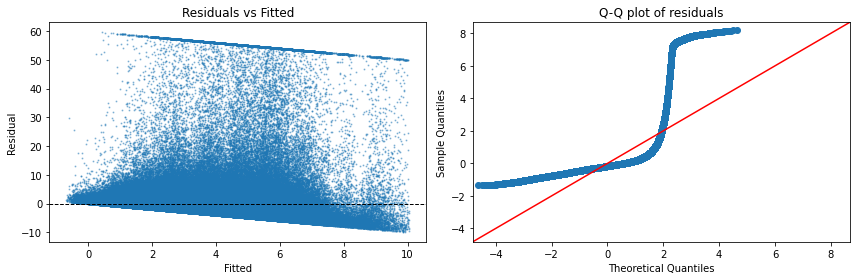

In [ ]:
resid = result.resid
fitted = result.fittedvalues

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Residuals vs Fitted
ax1.scatter(fitted, resid, s=1, alpha=0.4)
ax1.axhline(0, color='k', linestyle='--', linewidth=1)
ax1.set_xlabel('Fitted')
ax1.set_ylabel('Residual')
ax1.set_title('Residuals vs Fitted')

# Q-Q plot for residuals
sm.qqplot(resid, line='45', fit=True, ax=ax2)
ax2.set_title('Q-Q plot of residuals')

plt.tight_layout()